In [1]:
# [setup]
import os
from typing import TYPE_CHECKING, Union, cast

import matplotlib.pyplot as plt
import numpy as np

import habitat
from habitat.config.default_structured_configs import (
    CollisionsMeasurementConfig,
    FogOfWarConfig,
    TopDownMapMeasurementConfig,
)
from habitat.core.agent import Agent
from habitat.tasks.nav.nav import NavigationEpisode, NavigationGoal
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import (
    images_to_video,
    observations_to_image,
    overlay_frame,
)
from habitat_sim.utils import viz_utils as vut
from lmnav.config.default import get_config

# Quiet the Habitat simulator logging
os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"

if TYPE_CHECKING:
    from habitat.core.simulator import Observations
    from habitat.sims.habitat_simulator.habitat_simulator import HabitatSim


[2023-12-12 15:16:15,003] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# [example_4]
class ShortestPathFollowerAgent(Agent):
    r"""Implementation of the :ref:`habitat.core.agent.Agent` interface that
    uses :ref`habitat.tasks.nav.shortest_path_follower.ShortestPathFollower` utility class
    for extracting the action on the shortest path to the goal.
    """

    def __init__(self, env: habitat.Env, goal_radius: float):
        self.env = env
        self.shortest_path_follower = ShortestPathFollower(
            sim=cast("HabitatSim", env.sim),
            goal_radius=goal_radius,
            return_one_hot=False,
        )

    def act(self, observations: "Observations") -> Union[int, np.ndarray]:
        return self.shortest_path_follower.get_next_action(
            cast(NavigationEpisode, self.env.current_episode).goals[0].position
        )

    def reset(self) -> None:
        pass

In [3]:
import os

os.chdir("/srv/flash1/pputta7/projects/lm-nav")
config = get_config("train/nav_llama/1env_karmesh/bc/lora+clip+karmesh")
with habitat.config.read_write(config):
        config.habitat.task.measurements.update(
            {
                "top_down_map": TopDownMapMeasurementConfig(
                    map_padding=0,
                    map_resolution=128,
                    draw_source=False,
                    draw_border=False,
                    draw_shortest_path=False,
                    draw_view_points=False,
                    draw_goal_positions=False,
                    draw_goal_aabbs=False,
                    fog_of_war=FogOfWarConfig(
                        draw=False,
                        visibility_dist=5.0,
                        fov=90,
                    ),
                ),
                "collisions": CollisionsMeasurementConfig(),
            }
        )
    

In [4]:
config.habitat.dataset

{'type': 'PointNav-v1', 'split': 'train', 'scenes_dir': 'data/scene_datasets', 'content_scenes': ['00744-1S7LAXRdDqK'], 'data_path': 'data/datasets/imagenav/hm3d/v1/{split}/{split}.json.gz'}

In [5]:
dataset = habitat.make_dataset(
        id_dataset=config.habitat.dataset.type, config=config.habitat.dataset)

env = habitat.Env(config=config, dataset=dataset)
observations = env.reset()

2023-12-12 15:16:20,574 Initializing dataset PointNav-v1
2023-12-12 15:16:20,704 initializing sim Sim-v0
2023-12-12 15:16:21,588 Initializing task Nav-v0


In [6]:
def are_rectangles_disjoint(rects):
    """
    Check if a set of rectangles are disjoint (do not overlap).

    Args:
    rects (dict): A dictionary where keys are room names and values are tuples of top-left and bottom-right coordinates.

    Returns:
    bool: True if all rectangles are disjoint, False otherwise.
    """

    for room1, coords1 in rects.items():
        for room2, coords2 in rects.items():
            if room1 != room2:
                # Unpack the coordinates
                (x1_top, y1_top), (x1_bottom, y1_bottom) = coords1
                (x2_top, y2_top), (x2_bottom, y2_bottom) = coords2

                # Check for overlap
                if (x1_top < x2_bottom and x1_bottom > x2_top and
                        y1_top < y2_bottom and y1_bottom > y2_top):
                    return False
    return True

def get_room_of_pixel(pixel_coords, rooms):
    """
    Get the room name in which the given pixel is located.

    Args:
    pixel_coords (tuple): The coordinates of the pixel.
    rooms (dict): A dictionary of rooms with their coordinates.

    Returns:
    str: The name of the room in which the pixel is located, or 'None' if the pixel is not in any room.
    """
    room_list = []
    for room, coords in rooms.items():
        (x_top, y_top), (x_bottom, y_bottom) = coords
        if x_top <= pixel_coords[0] < x_bottom and y_top <= pixel_coords[1] < y_bottom:
            room_list.append(room)

    assert len(room_list) > 0, f"A pixel didn't get any room! ({pixel_coords})"
    assert len(room_list) <= 1, f"A pixel belongs to more than one room, which should not happen. ({pixel_coords})"
    return room_list[0] if room_list else None

def assign_rooms_to_pixels(image, rooms):
    """
    Assigns rooms to each pixel in the image.

    Args:
    image (numpy.ndarray): The grayscale image.
    rooms (dict): A dictionary of rooms with their coordinates.

    Returns:
    numpy.ndarray: An array representing the rooms each pixel belongs to.
    """
    h, w = image.shape
    room_assignment = np.full((h, w), None, dtype=object)  # Initialize with 'None'

    for i in range(h):
        for j in range(w):
            if image[i, j] == 1:
                room_assignment[i, j] = get_room_of_pixel((i, j), rooms)

    return room_assignment

In [11]:
agent = ShortestPathFollowerAgent(
            env=env,
            goal_radius=config.habitat.task.measurements.success.success_distance,
        )

# Load the first episode and reset agent
observations = env.reset()
agent.reset()

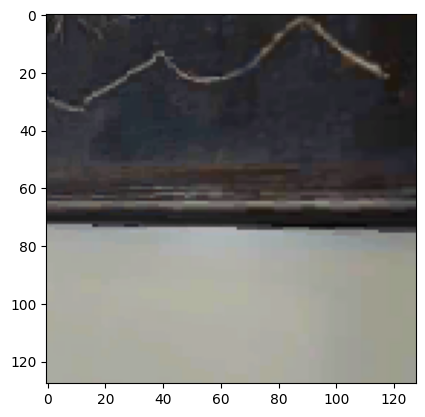

In [71]:
state = (env.sim.get_agent_state())
state.position =  [-6.017818927764893, 0.19160032272338867, -3.614501476287842]
env.sim.set_agent_state(state.position, state.rotation)

plt.imshow(env.sim.render())

(128, 152)


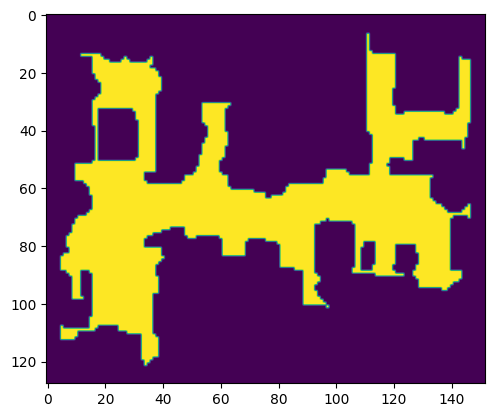

In [44]:
env.reset()
state = (env.sim.get_agent_state())
state.position = [-6.634757041931152, -1.0083996057510376, 1.3071434497833252]
env.sim.set_agent_state(state.position, state.rotation)

# Get metrics
info = env.get_metrics()
print(info['top_down_map']['map'].shape)
plt.imshow(info['top_down_map']['map'])

In [29]:
state.position

[-2.470123529434204, 0.19160032272338867, -4.356828689575195]

In [8]:
import random

random.seed(2)

# (128, 152)
    room0 = {
        "office room": [(0, 0), (128, 45)],
        "laundry room": [(0, 45), (60, 70)],
        "hallway": [(60, 45), (100, 70)],
        "living room": [(52, 70), (105, 150)],
        "bedroom": [(0, 100), (52, 150)]
    }
    
    room1 = {
        "bedroom 1": [(66, 95), (120, 150)],
        "bedroom 2": [(0, 95), (54, 150)],
        "hallway": [(54, 60), (66, 110)],
        "bathroom 1": [(0, 70), (40, 95)],
        "bathroom 2": [(66, 75), (100, 92)],
        "kitchen": [(0, 0), (66, 60)],
        "living room": [(66, 0), (120, 48)],
        "entrance": [(66, 48), (100, 68)]
    }

def random_color():
    return [random.randint(0, 255) for _ in range(3)]

image = info['top_down_map']['map']
image_rgb = np.zeros((*image.shape, 3), dtype=int)

# Setting pixels to (255, 255, 255) where the original image has 1s, and (0, 0, 0) where it has 0s
image_rgb[image == 1] = [255, 255, 255]
image_rgb[image == 0] = [0, 0, 0]


for room, coords in rooms.items():
    color = random_color()
    top_left, bottom_right = coords

    # Only update pixels where the original image had a value of 1
    for i in range(top_left[0], bottom_right[0]):
        for j in range(top_left[1], bottom_right[1]):
            if image[i, j] == 1:
                image_rgb[i, j, :] = color

# Display the updated image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

IndentationError: unexpected indent (44672333.py, line 6)

In [ ]:
are_rectangles_disjoint(rooms)
assign_rooms_to_pixels(image, rooms)

In [ ]:
test = image_rgb.copy()
test[15, 143] = np.array([255, 0, 0])
plt.imshow(test)

In [13]:
dir(env.sim.semantic_annotations())

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'aabb',
 'categories',
 'levels',
 'load_mp3d_house',
 'objects',
 'regions',
 'semantic_index_map',
 'semantic_index_to_object_index']

In [17]:
(env.sim.semantic_annotations().aabb.centers)

AttributeError: 'habitat_sim._ext.habitat_sim_bindings.BBox' object has no attribute 'centers'

In [48]:
from habitat.utils.visualizations.maps import get_topdown_map 

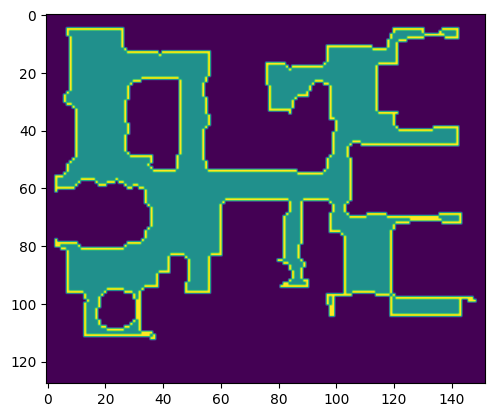

In [62]:
plt.imshow(get_topdown_map(env.sim.pathfinder, -0, 128))